<a href="https://colab.research.google.com/github/AnIsAsPe/Regresion-Robusta-para-estimar-tiempo-de-respuesta-de-un-servicio-de-emergencia/blob/main/Notebook/1_Response_time_Paris_Fire_Brigade_202505.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cargar bibiliotecas y funciones

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler         # solamente para la comparación da la improtancia entre variables explicativas

from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def correlacion(dataframe, grafica=True, matrix=True, tamaño =(6, 4)):
    '''
    Funcion para obtener la matriz de correlacion y visualizarla en mapa de calor.
    '''
    corr=dataframe.corr()
    if grafica==True:
      fig = plt.figure(figsize = tamaño)
      ax = sns.heatmap(corr,
                       vmin = -1,
                       vmax = 1,
                       center = 0,
                       cmap = "coolwarm",
                       annot = True,
                       fmt=".2f",
                       square = True)
      ax.set_xticklabels(ax.get_xticklabels(),
                         rotation = 45,
                         horizontalalignment ='right')
    if matrix==True:
      return corr

In [ ]:
def describe_datos(df):
    """
    Función para describir un DataFrame de pandas.

    Devuelve:
    --------
    DataFrame
        Devuelve un DataFrame con la descripción de cada columna, incluyendo:
    (1) Tipo de columna, (2) Número de valores nulos, (3) Porcentaje de valores nulos
    (4) Número de valores únicos y (5) Valores únicos

    """

    unicos =[]
    for col in df:
        unicos.append(df[col].unique())
    unicos = pd.Series(unicos, index=df.columns)
    descripcion = pd.concat(
        [
            df.dtypes,
            df.isna().sum(),
            round(df.isna().sum()/len(df)*100, 1),
            df.nunique(),
            unicos
        ],
        axis=1
    )

    descripcion.columns = ['dtypes', 'null', '%null', 'nunique', 'unique']
    return descripcion

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calcula la distancia Haversine entre dos puntos en la tierra.

    Parameteros:
    lat1 (pd.Series or float): Latitud de punto inicial en grados.
    lon1 (pd.Series or float): Longitud del punto inicial en grados.
    lat2 (pd.Series or float): Latitud del punto final en grados.
    lon2 (pd.Series or float): Longitud del punto final en grados.

    Devuelve:
    pd.Series or float: Haversine distance(s) in kilometers.
    """
    R = 6371  # Radius of Earth in kilometers

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

In [ ]:
# Function to plot categorical data with relative frequency
def plot_categorical_relative_frequency(df, column, fig_size=(15,5)):
    counts = df[column].value_counts()
    plt.figure(figsize=fig_size)
    # Orden basado en la frecuencia
    order = counts.index
    counts.plot(kind='bar')
    plt.title(f'Categorías de {column} ')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

def plot_categorical_boxplot(df, column, fig_size=(15,5)):
    counts = df[column].value_counts()
    plt.figure(figsize=fig_size)
    # Get the order of categories based on frequency from the previous step
    order = df[column].value_counts().index.tolist()
    sns.boxplot(x=column, y='delta departure-presentation', data=df, showfliers=False, order=order)
    plt.title(f'Delta Departure-Presentation por {column} ')
    plt.xlabel(column)
    plt.ylabel('Delta Departure-Presentation')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

# Lectura datos y selección de características

__Cargar etiquetas__

In [ ]:
# Variables respuesta
Ys = pd.read_csv('drive/My Drive/Datos/ParisFireBrigade/y_train.csv',
                     index_col=[0], sep=',',)
print(Ys.shape)
Ys.head(2)

(219337, 3)


,delta selection-departure,delta departure-presentation,delta selection-presentation
emergency vehicle selection,,,
5105452,86,324,410
4720915,164,297,461


In [ ]:
# Se puede verificar si la última columna es la suma de las otras dos
(Ys.iloc[:,0] + Ys.iloc[:,1] == Ys.iloc[:,2]).sum()==len(Ys)

np.True_

Nos vamos a concentrar en el tiempo desde la salida del vehículo hasta la presentación en el lugar del siniestro

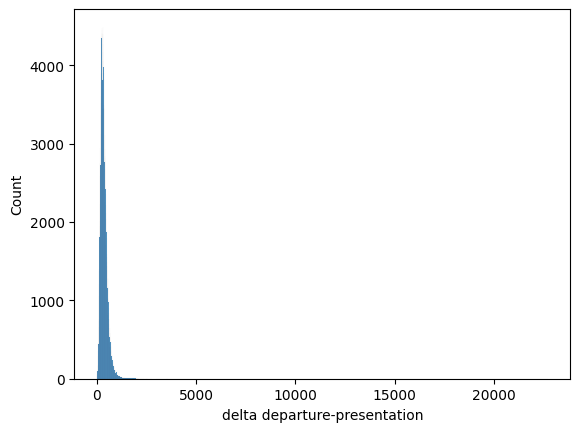

In [ ]:
sns.histplot(df['delta departure-presentation'])
plt.show()

__Cargar características__

In [ ]:
# Conjunto de caracteristicas (X)
X = pd.read_csv('drive/My Drive/Datos/ParisFireBrigade/x_train.csv',
                sep=',', index_col=[0], parse_dates=['selection time'] )
print(X.shape)
X.head(2)

(219337, 25)


,intervention,alert reason category,alert reason,intervention on public roads,floor,location of the event,longitude intervention,latitude intervention,emergency vehicle,emergency vehicle type,...,delta status preceding selection-selection,departed from its rescue center,longitude before departure,latitude before departure,delta position gps previous departure-departure,GPS tracks departure-presentation,GPS tracks datetime departure-presentation,OSRM response,OSRM estimated distance,OSRM estimated duration
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,
5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,VSAV BSPP,...,2027,1,2.288053,48.884698,NaN,"2.289000,48.885113;2.288861,48.884998;2.288000...",2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,"{""code"":""Ok"",""routes"":[{""geometry"":""}yjiH}x}L_...",952.5,105.8
4720915,12663715,3,2124,0,1,136.0,2.247464,48.818191,4327,PSE,...,28233,1,2.268519,48.823958,NaN,NaN,NaN,"{""code"":""Ok"",""routes"":[{""geometry"":""u|~hHy`zL_...",2238.5,243.2


In [ ]:
describe_datos(X)

,dtypes,null,%null,nunique,unique
intervention,int64,0,0.0,200894,"[13264186, 12663715, 13675521, 12695745, 13698..."
alert reason category,int64,0,0.0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
alert reason,int64,0,0.0,126,"[2162, 2124, 2163, 2112, 2711, 2113, 2135, 212..."
intervention on public roads,int64,0,0.0,2,"[0, 1]"
floor,int64,0,0.0,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,float64,12710,5.8,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
longitude intervention,float64,0,0.0,83484,"[2.284796, 2.247464, 2.258328, 2.393832, 2.458..."
latitude intervention,float64,0,0.0,74503,"[48.879669, 48.818191, 48.836759, 48.776526, 4..."
emergency vehicle,int64,0,0.0,749,"[4511, 4327, 4509, 5731, 5623, 4319, 4215, 588..."
emergency vehicle type,object,0,0.0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."


La cantidad de intervenciones en los datos no es igual a la cantidad de vehículos, De manera que existen intervenciones que son atendidas por más de un vehiculo de emergencia

el análisis lo vamos a hacer por vehículo

In [ ]:
# Borrar columnas que no utilizaremos

col_borrar=['intervention',  #identificador de la intervención

            # Redundantes
            'date key sélection', 'time key sélection', # incluidas en 'selection time'
            'emergency vehicle',  # 749 categorias, que están resumidas en 75 'emergency vehicle type'
            'alert reason', # 126 categorías, que están resumidas en 9 'alert reason category'

            # Variables geográficas
            'OSRM response',                              # rutas
            'GPS tracks departure-presentation',          # rutas
            'GPS tracks datetime departure-presentation', # rutas
            # 'longitude intervention', 'latitude intervention', # coordenadas
            # 'longitude before departure',                      # coordenadas
            # 'latitude before departure',                       # coordenadas

            # Variable no relaccionadas con delta departure-presentation
            'status preceding selection',
            'rescue center', # id 94 centros de rescate, estacionamiento de los vehícuos
            'delta status preceding selection-selection',
            'departed from its rescue center',
            'delta position gps previous departure-departure'
            ]
X = X.drop(columns= col_borrar)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219337 entries, 5105452 to 4868867
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   alert reason category         219337 non-null  int64         
 1   intervention on public roads  219337 non-null  int64         
 2   floor                         219337 non-null  int64         
 3   location of the event         206627 non-null  float64       
 4   longitude intervention        219337 non-null  float64       
 5   latitude intervention         219337 non-null  float64       
 6   emergency vehicle type        219337 non-null  object        
 7   selection time                219337 non-null  datetime64[ns]
 8   longitude before departure    219337 non-null  float64       
 9   latitude before departure     219337 non-null  float64       
 10  OSRM estimated distance       219337 non-null  float64       
 11  OSRM estima

__Unir caracteristicas con étiquetas__

In [ ]:
df = pd.concat([X,  Ys['delta departure-presentation']], axis=1)
print(df.shape)


(219337, 13)


<h2> Idetificación del tipo de variable de cada columna

Comparamos el tipo de cada columna con la documentación de los parámetros de entrada en [la documentación provista por el Challenge](https://paris-fire-brigade.github.io/data-challenge/challenge.html)

In [ ]:
categorical_cols=['alert reason category','location of the event','emergency vehicle type']
df[categorical_cols] = df[categorical_cols].astype('object')

describe_datos(df)

,dtypes,null,%null,nunique,unique
alert reason category,object,0,0.0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
intervention on public roads,int64,0,0.0,2,"[0, 1]"
floor,int64,0,0.0,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,object,12710,5.8,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
longitude intervention,float64,0,0.0,83484,"[2.284796, 2.247464, 2.258328, 2.393832, 2.458..."
latitude intervention,float64,0,0.0,74503,"[48.879669, 48.818191, 48.836759, 48.776526, 4..."
emergency vehicle type,object,0,0.0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."
selection time,datetime64[ns],0,0.0,219285,"[2018-07-08 19:02:43.990000, 2018-01-04 09:02:..."
longitude before departure,float64,0,0.0,3093,"[2.288053, 2.268519, 2.272944, 2.3889400000000..."
latitude before departure,float64,0,0.0,2798,"[48.884698, 48.82395800000001, 48.850498, 48.7..."


# Creación de nuevas variables

## A partir de 'selection time'

In [ ]:
df['hour'] = (df['selection time'].dt.hour +
                              df['selection time'].dt.minute / 60 +
                              df['selection time'].dt.second / 3600)
df['day_of_week'] = df['selection time'].dt.day_name()
df['weekend'] = df['selection time'].dt.dayofweek > 4
df['month'] = df['selection time'].dt.month_name()

Rush hour: variable binaria para identificar eventos en horas pico

In [ ]:
df['rush hour'] = 0

# Poner como indice 'selection time'
df = df.reset_index()
df = df.set_index('selection time')

# identificar el indice de los registros de eventos en hora pico
pico_am = df.index.indexer_between_time('6:30','9:30')
pico_pm = df.index.indexer_between_time('16:00','19:00')
horas_pico_index= np.concatenate((pico_am, pico_pm))

# cambiar el valor de 'rush hour' a uno cuando sea horas pico
df.iloc[list(horas_pico_index),-1] = 1

# Regresar a 0 el valor para los días sabados y domingos
df['rush hour']= np.where(df['weekend']==True, 0, df['rush hour'])

# Regresar emerency vehicle selection como indice
df = df.reset_index()
df = df.set_index('emergency vehicle selection')

In [ ]:
France_hollidays = {
    '02/01/2018': "New Year's Day",
    '02/04/2018': "Easter Monday",
    '01/05/2018': "Labor Day",
    '08/05/2018': "WWII Victory Day",
    '10/05/2018': "Ascension Day",
    '21/05/2018': "Whit Monday",
    '14/07/2018': "Bastille Day",
    '15/08/2018': "Assumtion of Mary",
    '01/11/2018': "All' Saints' Day",
    '11/11/2018': "Armistice Day",
    '25/12/1973': "Christmas Day",
}
# https://www.timeanddate.com/holidays/france/2018?hol=9

In [ ]:
# prompt: # prompt: create column in df based in 'selection time' column and the dictionary France_hollidays

df['is_holiday'] = df['selection time'].dt.strftime('%d/%m/%Y').isin(France_hollidays.keys()).astype(int)

In [ ]:
df[['selection time', 'hour', 'day_of_week', 'month', 'rush hour','weekend', 'is_holiday']].head()

,selection time,hour,day_of_week,month,rush hour,weekend,is_holiday
emergency vehicle selection,,,,,,,
5105452,2018-07-08 19:02:43.990,19.045278,Sunday,July,0,True,0
4720915,2018-01-04 09:02:59.470,9.049722,Thursday,January,1,False,0
5365374,2018-11-16 10:11:47.777,10.196389,Friday,November,0,False,0
4741586,2018-01-15 00:38:46.820,0.646111,Monday,January,0,False,0
5381209,2018-11-24 00:34:26.017,0.573889,Saturday,November,0,True,0


## A partir de longitud, latitud y distancia OSMR

Primero calculamos la Distancia Haversine  partir de latitud y longitud de salida y llegada del vehiculo de emergencia.
Despues anlizaremos la relación con la distancia OSMR


In [ ]:
df['haversine_distance_km'] = haversine(
    df['latitude intervention'],
    df['longitude intervention'],
    df['latitude before departure'],
    df['longitude before departure']
)

df.haversine_distance_km.describe()

,haversine_distance_km
count,219337.000000
mean,1.472756
std,1.134081
min,0.002434
25%,0.742183
50%,1.209354
75%,1.898958
max,30.931014


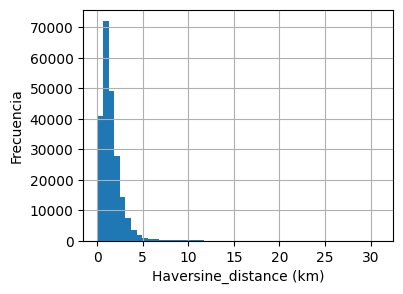

In [ ]:
plt.figure(figsize=(4, 3))
df.haversine_distance_km.hist(bins=50)
plt.xlabel('Haversine_distance (km)')
plt.ylabel('Frecuencia')
plt.show()

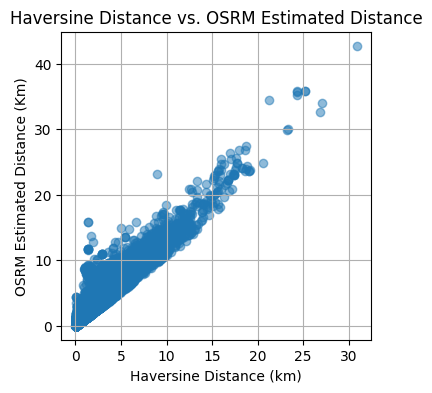

Correlation between Haversine Distance and OSRM Estimated Distance: 0.9385


In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(df['haversine_distance_km'], df['OSRM estimated distance']/1000, alpha=0.5)
plt.title('Haversine Distance vs. OSRM Estimated Distance')
plt.xlabel('Haversine Distance (km)')
plt.ylabel('OSRM Estimated Distance (Km)')
plt.grid(True)
plt.show()

correlation = df['haversine_distance_km'].corr(df['OSRM estimated distance'])
print(f"Correlation between Haversine Distance and OSRM Estimated Distance: {correlation:.4f}")

In [ ]:
# Crearmos una nueva columna con la diferencia entre las distancias
# Esta diferencia nos proporciona información sobre la complejidad y conectividad del camino.

# Es necesario unificar las unidades.

df['Road_Network_Complexity_Factor'] =  (df['OSRM estimated distance'] / 1000) / df['haversine_distance_km']



In [ ]:
df.drop(
    columns=['latitude intervention','longitude intervention',
             'latitude before departure','longitude before departure',
             'selection time'],
    inplace=True
)

# Manejo de Valores Nulos

In [ ]:
describe_datos(df)

,dtypes,null,%null,nunique,unique
alert reason category,object,0,0.0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
intervention on public roads,int64,0,0.0,2,"[0, 1]"
floor,int64,0,0.0,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,object,12710,5.8,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
emergency vehicle type,object,0,0.0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."
OSRM estimated distance,float64,0,0.0,48461,"[952.5, 2238.5, 3026.4, 1934.2, 2706.7, 1685.8..."
OSRM estimated duration,float64,0,0.0,8236,"[105.8, 243.2, 295.4, 166.6, 262.6, 187.7, 301..."
delta departure-presentation,int64,0,0.0,1909,"[324, 297, 365, 160, 523, 419, 452, 404, 411, ..."
hour,float64,0,0.0,76301,"[19.04527777777778, 9.049722222222222, 10.1963..."
day_of_week,object,0,0.0,7,"[Sunday, Thursday, Friday, Monday, Saturday, T..."


In [ ]:
df['location of the event'].value_counts(dropna=False)/len(df)*100

,count
location of the event,
139.0,23.266024
136.0,20.242823
148.0,14.588054
NaN,5.794736
149.0,4.515882
...,...
290.0,0.000456
265.0,0.000456
302.0,0.000456



**Alternativas**
- Borrar esos renglones,
- borrar esa variable,
- imputar valores:
   - ¿remplazar por ceros?
   - ¿reemplazar por una medida de tendencia central?
   - ¿a parir del conocimiento que nos proporcionan las demás variables?

In [ ]:
moda = df['location of the event'].mode().values[0]
df['location of the event'] = df['location of the event'].infer_objects(copy=False).fillna(moda)
# regresar a tipo objeto, para distinguirla como variable categórica
df['location of the event'] = df['location of the event'].astype('int').astype('object')

In [ ]:
df.isna().sum()

,0
alert reason category,0
intervention on public roads,0
floor,0
location of the event,0
emergency vehicle type,0
OSRM estimated distance,0
OSRM estimated duration,0
delta departure-presentation,0
hour,0
day_of_week,0


# Exploración y selección de variables

## Variables booleanas

In [ ]:
booleanas_cols=[]
for col in df.columns:
  if df[col].nunique()==2:
    booleanas_cols.append(col)
df[booleanas_cols]=df[booleanas_cols].astype('bool')
booleanas_cols

['intervention on public roads', 'weekend', 'rush hour', 'is_holiday']

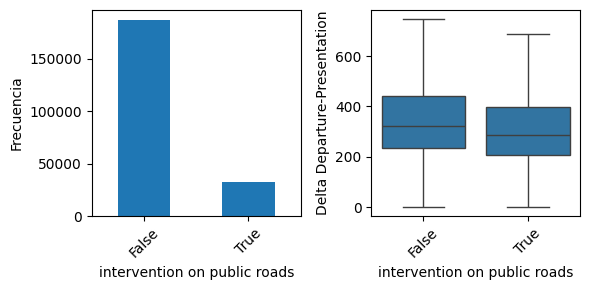

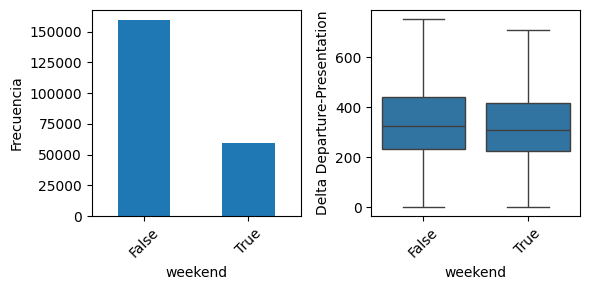

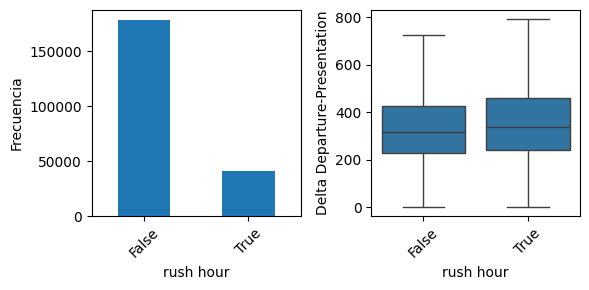

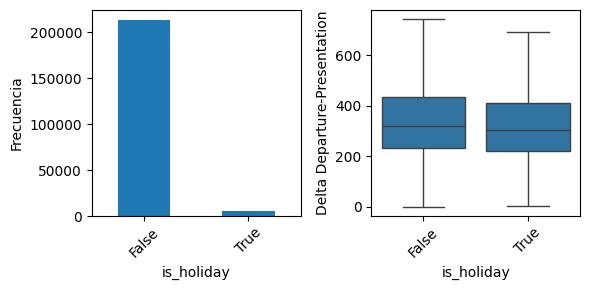

In [ ]:
for column in booleanas_cols:
    fig, axes = plt.subplots(1, 2, figsize=(6, 3)) # Create a figure with 1 row and 2 columns

    # Plot relative frequency
    counts = df[column].value_counts()
    counts.plot(kind='bar', ax=axes[0])
    # axes[0].set_title(f'Categorías de {column} ')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frecuencia')
    axes[0].tick_params(axis='x', rotation=45)


    # Plot boxplot
    order = counts.index.tolist() # Use the same order as the frequency plot
    sns.boxplot(x=column, y='delta departure-presentation', data=df, showfliers=False, order=order, ax=axes[1])
    # axes[1].set_title(f'Delta Departure-Presentation por {column} ')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Delta Departure-Presentation')
    axes[1].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

## Numéricas

Identificar y eliminar variables:

1. **No relevantes**: Análisis de correlación de las explicativas(X) con la etiqueta (y)


2. **Redundantes**: Análisis de correlación entre las variables explicativas (X)

In [ ]:
numericas_cols = list(df.select_dtypes(include=['int64', 'float64']).columns)
numericas_cols

['floor',
 'OSRM estimated distance',
 'OSRM estimated duration',
 'delta departure-presentation',
 'hour',
 'haversine_distance_km',
 'Road_Network_Complexity_Factor']

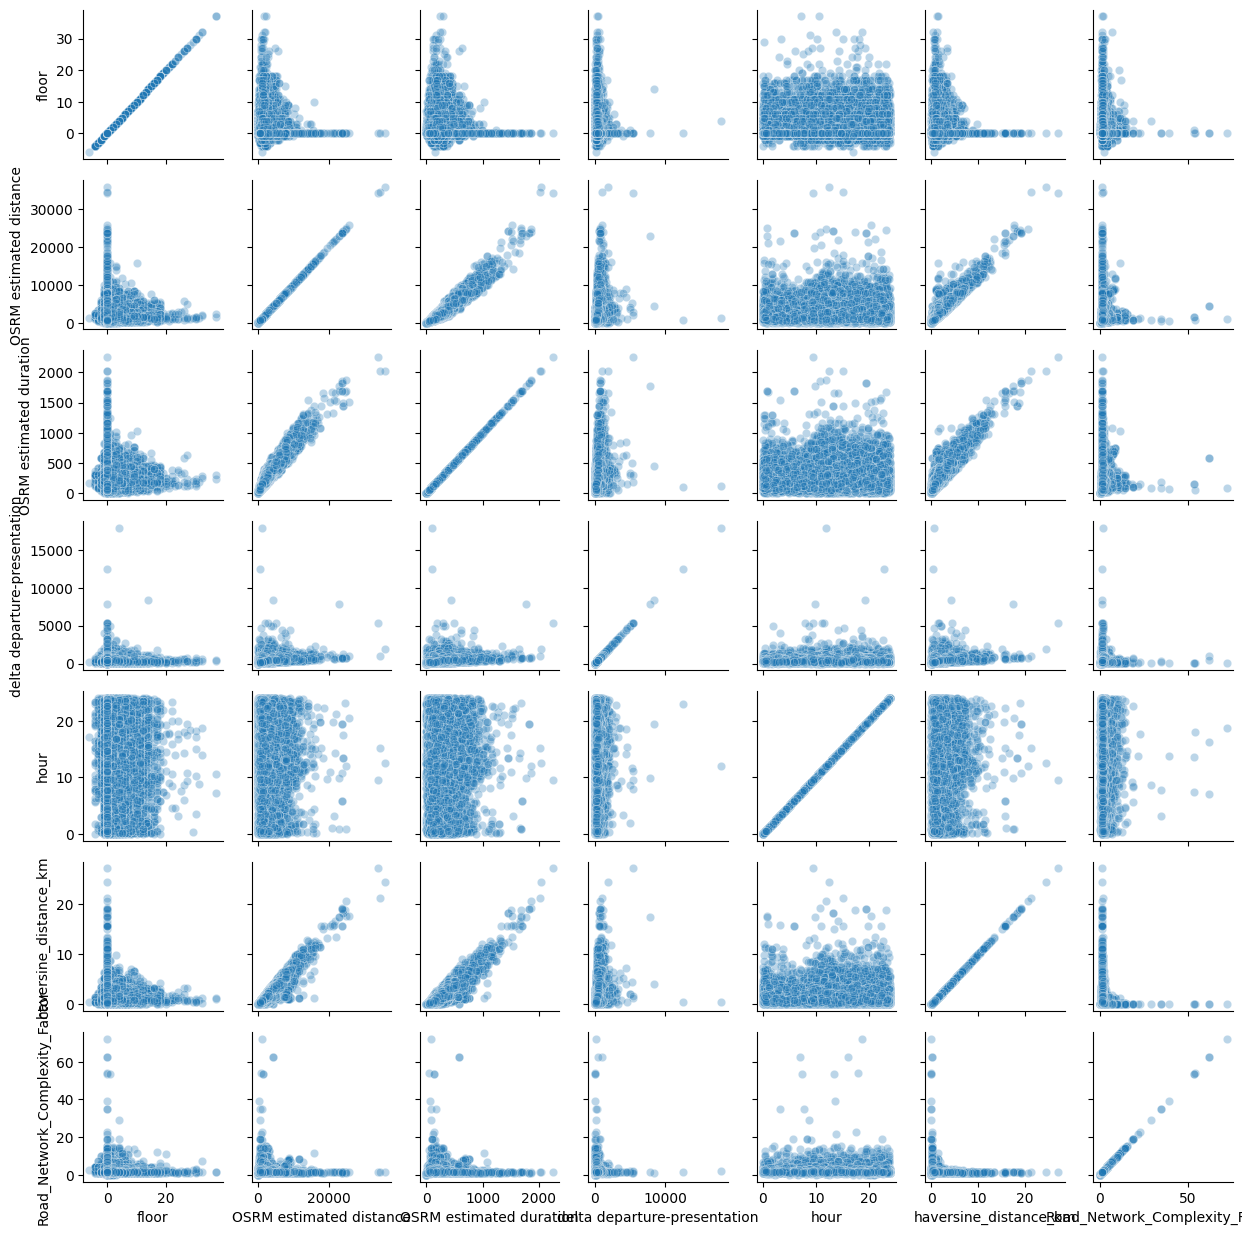

In [ ]:
g = sns.PairGrid(df[numericas_cols].sample(frac=.25), height= 1.8)
g.map(sns.scatterplot, alpha=0.3)
plt.show()

<h2> ¿Hay variables que no son relevantes para la predicción de la variable respuesta?

In [ ]:
corr_y = df[numericas_cols].corr()['delta departure-presentation']
corr_y

,delta departure-presentation
floor,0.002170
OSRM estimated distance,0.449922
OSRM estimated duration,0.446742
delta departure-presentation,1.000000
hour,-0.019854
haversine_distance_km,0.441511
Road_Network_Complexity_Factor,-0.055925


In [ ]:
no_relevantes = corr_y.loc[corr_y.abs()<0.05].index.to_list()
no_relevantes

['floor', 'hour']

<h2> ¿Hay variables redundantes entre las variables explicativas?

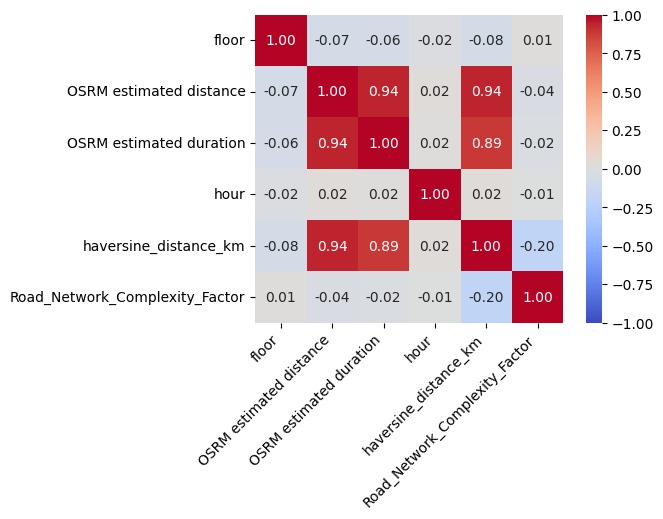

In [ ]:
# correlacion de las características numéricas en el conjunto X
corr_matrix = correlacion(df[numericas_cols].drop('delta departure-presentation', axis=1))


In [ ]:
#Identificar variables redundantes

# Triangulo superior de la matriz de correlación en números absolutos
celda_sobre_diagonal_ppal = np.triu(np.ones_like(corr_matrix), 1).astype(bool)
triangulo_sup = corr_matrix.where(celda_sobre_diagonal_ppal).abs()


# Encontrar las columnas donde la correlación es 1
redundantes = [column for column in triangulo_sup.columns
          if any(triangulo_sup[column] >= .7)]
redundantes

['OSRM estimated duration', 'haversine_distance_km']

In [ ]:
df = df.drop(redundantes + no_relevantes, axis=1)

In [ ]:
df.columns

Index(['alert reason category', 'intervention on public roads',
       'location of the event', 'emergency vehicle type',
       'OSRM estimated distance', 'delta departure-presentation',
       'day_of_week', 'weekend', 'month', 'rush hour', 'is_holiday',
       'Road_Network_Complexity_Factor'],
      dtype='object')

##  Variables categóricas

In [ ]:
categoricas_cols = df.select_dtypes(include='object').columns
df[categoricas_cols].nunique()

,0
alert reason category,9
location of the event,210
emergency vehicle type,75
day_of_week,7
month,11


In [ ]:
df['month'].unique()  # falta septiembre

array(['July', 'January', 'November', 'August', 'October', 'May',
       'December', 'February', 'April', 'March', 'June'], dtype=object)

¿Vale la pena considerar todas las categorias para el one hot encodig?

In [ ]:
len(df)*0.001

219.33700000000002

In [ ]:
min_frec = len(df)*0.001

for col in categoricas_cols:
  counts = df[col].value_counts()
  cat_frecuentes = counts[counts >= min_frec]
  print(f"{len(cat_frecuentes):2} de {df[col].nunique():3} categorias cumplen con la frec minima en '{col}'")

 9 de   9 categorias cumplen con la frec minima en 'alert reason category'
65 de 210 categorias cumplen con la frec minima en 'location of the event'
16 de  75 categorias cumplen con la frec minima en 'emergency vehicle type'
 7 de   7 categorias cumplen con la frec minima en 'day_of_week'
11 de  11 categorias cumplen con la frec minima en 'month'


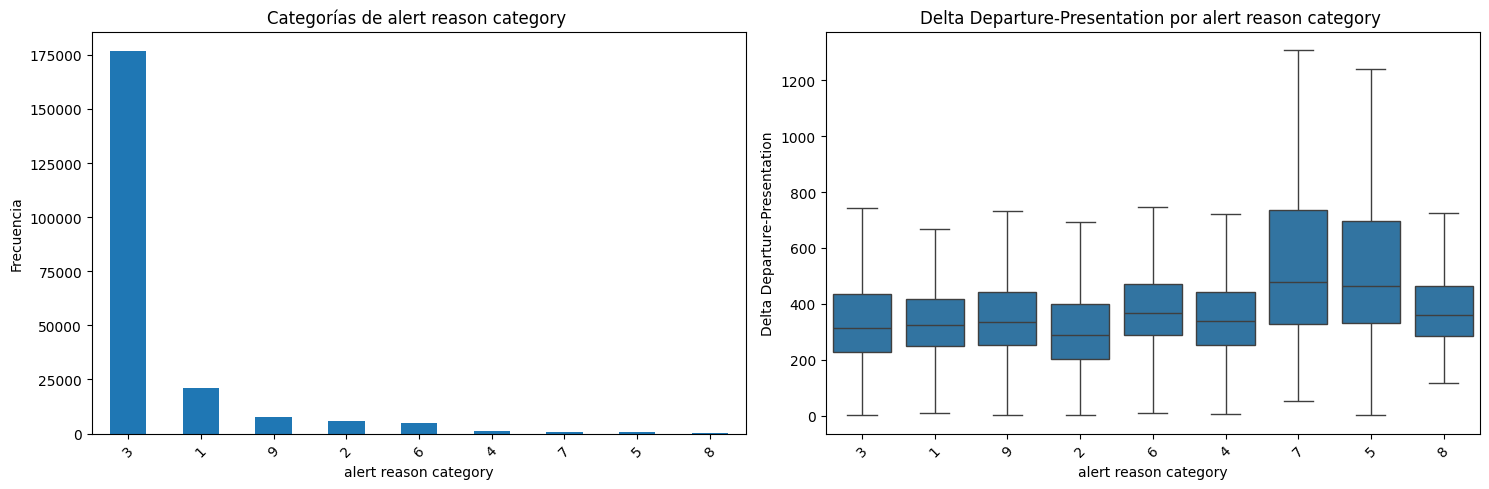

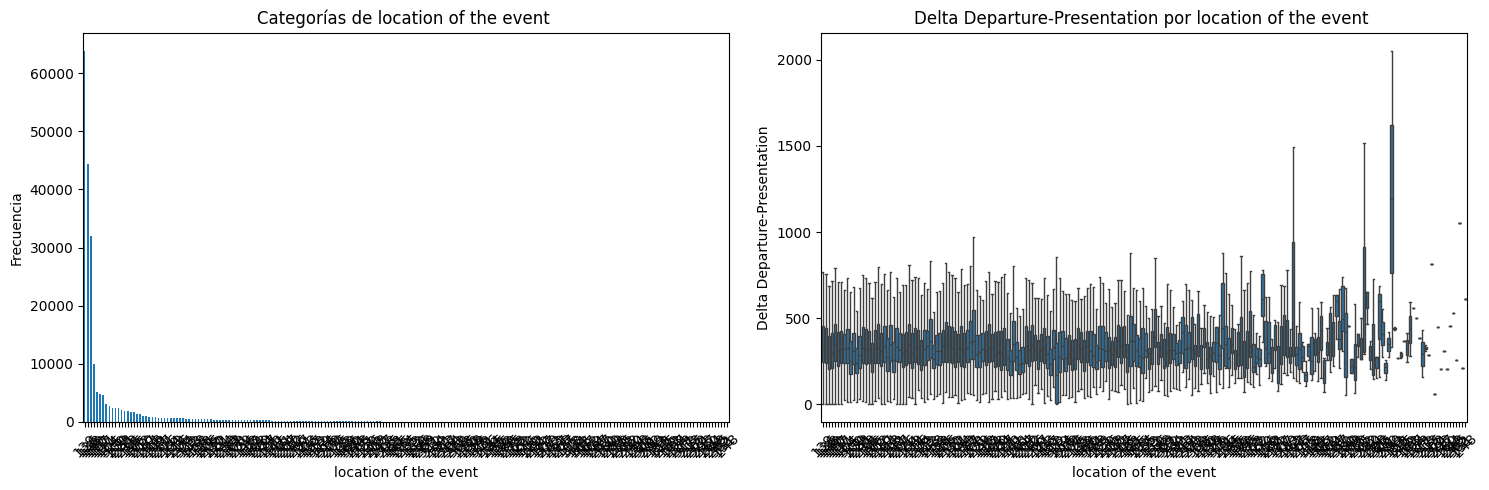

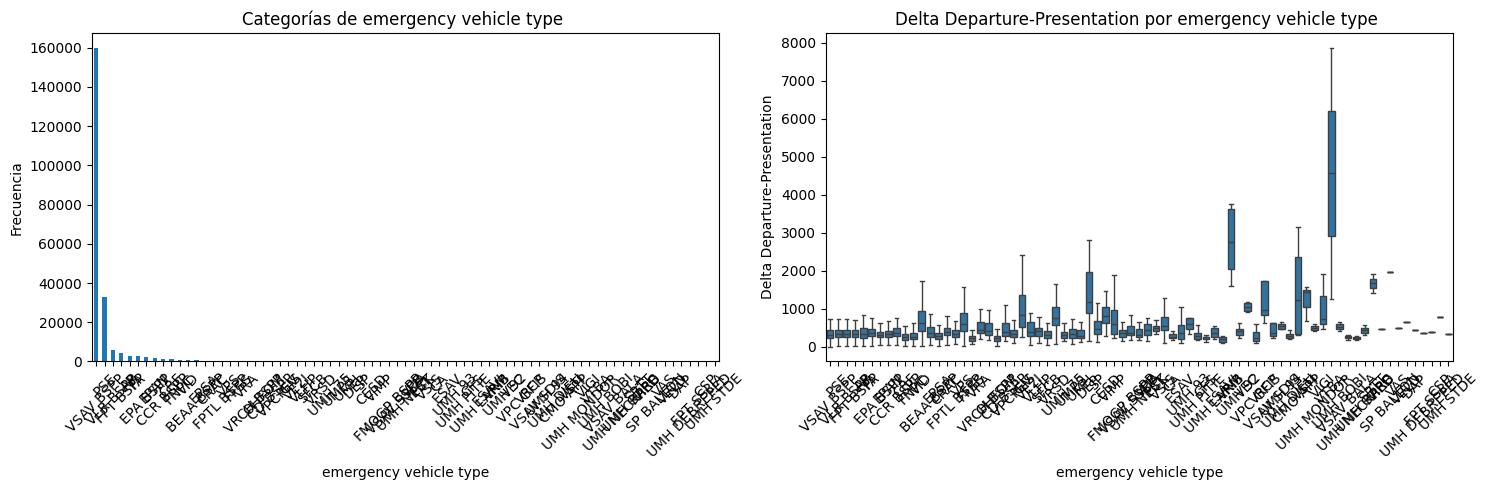

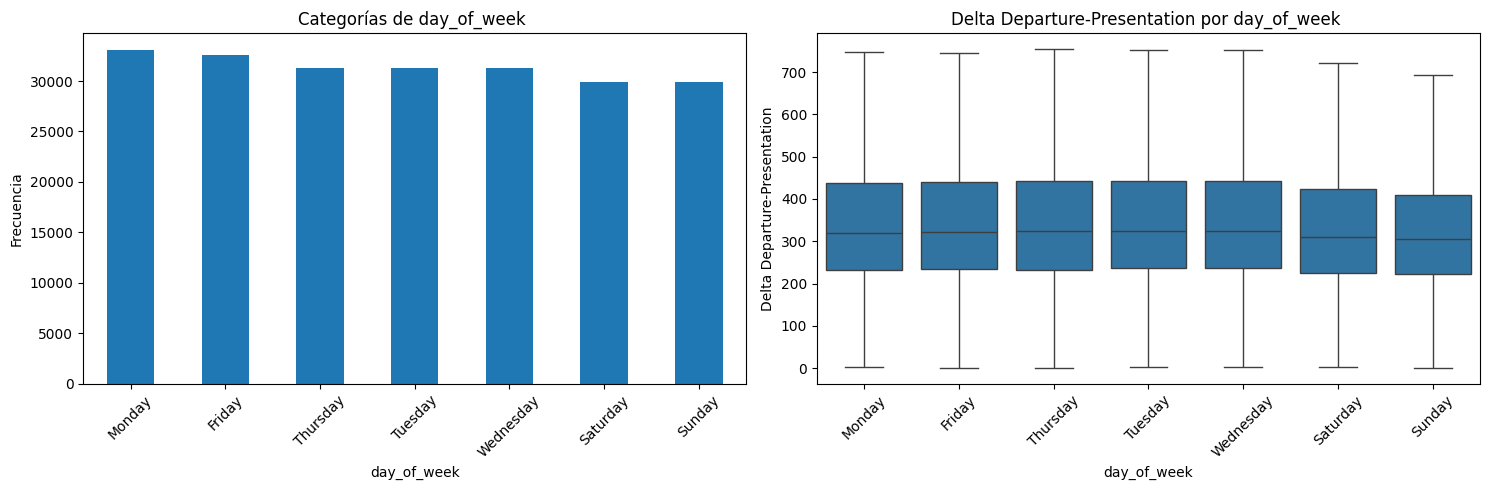

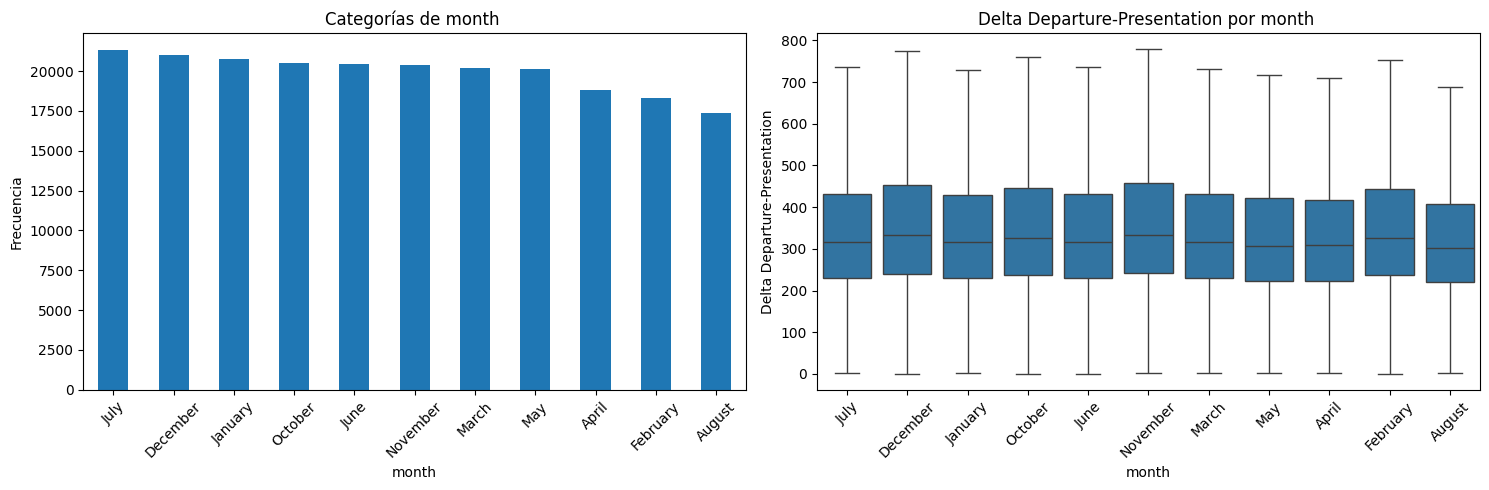

In [ ]:
for col in categoricas_cols:
    counts = df[col].value_counts()
    order = counts.index.tolist()

    fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # Create a figure with 1 row and 2 columns

    # Plot relative frequency
    counts.plot(kind='bar', ax=axes[0])
    axes[0].set_title(f'Categorías de {col} ')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frecuencia')
    axes[0].tick_params(axis='x', rotation=45)

    # Plot boxplot
    sns.boxplot(x=col, y='delta departure-presentation', data=df, showfliers=False, order=order, ax=axes[1])
    axes[1].set_title(f'Delta Departure-Presentation por {col} ')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Delta Departure-Presentation')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=.001)
encoder.fit(df[categoricas_cols]).set_output(transform = 'pandas')
he = encoder.transform(df[categoricas_cols])
len(he.columns)

110

In [ ]:
df.shape, he.shape

((219337, 12), (219337, 110))

In [ ]:
df = df.drop(columns=categoricas_cols)
df = pd.concat([df, he], axis=1)
#Llevar la etiqueta hasta la ultima posición
df = df[[c for c in df if c != 'delta departure-presentation'] + ['delta departure-presentation']]
df.shape

(219337, 117)

# Modelo de Regresión

In [ ]:
y = df['delta departure-presentation']
X = df.drop([ 'delta departure-presentation'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=261)

print("Conjunto de entrenamiento")
print("X: ", X_train.shape)
print("y: ", y_train.shape)

print("Conjunto de prueba")
print("X: ", X_test.shape)
print("y: ", y_test.shape)

Conjunto de entrenamiento
X:  (153535, 116)
y:  (153535,)
Conjunto de prueba
X:  (65802, 116)
y:  (65802,)


In [ ]:
# Línea base (error medio absoluto)
ema_base = np.mean(np.absolute(y_test - y_train.mean()))
print(f"""
El error de predecir el promedio del tiempo de respuesta,
sin usar las caracteristicas explicativas (X) es {ema_base:.2f}
      """)


El error de predecir el promedio del tiempo de respuesta, 
sin usar las caracteristicas explicativas (X) es 136.58
      


## Regresión Lineal

In [ ]:
lr = LinearRegression().fit(X_train, y_train)

y_pred = lr.predict(X_test)

error_medio_absoluto = np.mean(np.absolute(y_test - y_pred ))
error_medio_absoluto

np.float64(106.57957296291833)

<h2> Análisis de errores

Tenemos dos tipos de errores:


 1) Cuando la predicción es más baja que el valor real  $ ~~~~ y > \hat{y} $

 2) Cuando la predicción es más alta que el valor real $ ~~~~ y < \hat{y} $



In [ ]:
errores = (y_test - y_pred)
print(f'kurtosis: {kurtosis(errores)}')


kurtosis: 1313.0714458084258


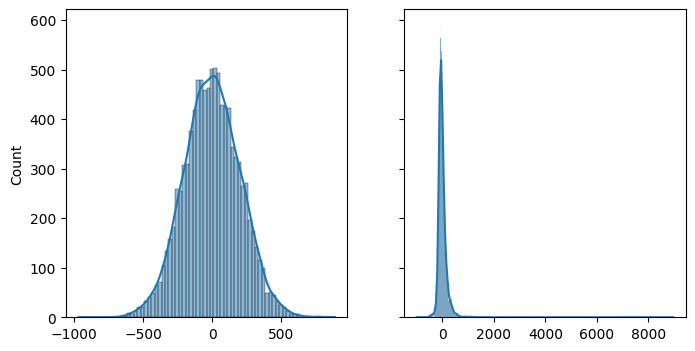

In [ ]:
# Comparación de la distribución teórica(normal) y empirica de los errores

media = np.mean(errores)
des_est = np.std(errores)
errores_teoricos = np.random.normal(media, des_est, 10000)
muestra_errores = np.random.choice(errores, 10000)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
for dat, subplot in zip((errores_teoricos, muestra_errores), ax.flatten()):
    sns.histplot(x=dat, ax=subplot, kde=True )

plt.show()

## Regresión Robusta

In [ ]:
hr = HuberRegressor(epsilon=1,   max_iter=1000,  alpha=0,  warm_start=False,
                    fit_intercept=True, tol=1e-05)
hr = hr.fit(X_train, y_train)
y_pred_hr = hr.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_hr))

MAE: 104.56990447649062


In [ ]:
#calculamos los errores
y_pred_hr = hr.predict(X_test)
errores_hr = (y_test - y_pred_hr)
print(f'kurtosis: {kurtosis(errores_hr)}')

## Regresión Ridge

In [ ]:
X_estandarizados = X.copy()
columnas = X.columns

scaler = StandardScaler()

X_estandarizados[columnas] = scaler.fit_transform(X[columnas])

In [ ]:
X_estandarizados.describe()

,intervention on public roads,OSRM estimated distance,weekend,rush hour,is_holiday,Road_Network_Complexity_Factor,alert reason category_1,alert reason category_2,alert reason category_3,alert reason category_4,...,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October
count,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,...,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05
mean,3.602327e-17,5.312784e-17,-5.818146e-17,-2.954426e-17,-2.847523e-17,1.554961e-16,3.508381e-17,-3.242742e-17,1.058669e-16,-4.353891e-17,...,-7.470293e-17,-2.883157e-17,5.698285e-17,1.645667e-17,6.090264e-18,1.001006e-17,7.865512e-17,-8.283408e-17,7.175498e-18,-3.210347e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-4.143257e-01,-1.405675e+00,-6.124556e-01,-4.785960e-01,-1.665940e-01,-1.605881e+00,-3.277009e-01,-1.634160e-01,-2.038334e+00,-7.481937e-02,...,-2.930537e-01,-3.256496e-01,-3.019423e-01,-3.233926e-01,-3.282892e-01,-3.205985e-01,-3.185450e-01,-3.181975e-01,-3.201833e-01,-3.212984e-01
25%,-4.143257e-01,-6.389835e-01,-6.124556e-01,-4.785960e-01,-1.665940e-01,-3.616905e-01,-3.277009e-01,-1.634160e-01,4.905967e-01,-7.481937e-02,...,-2.930537e-01,-3.256496e-01,-3.019423e-01,-3.233926e-01,-3.282892e-01,-3.205985e-01,-3.185450e-01,-3.181975e-01,-3.201833e-01,-3.212984e-01
50%,-4.143257e-01,-2.333023e-01,-6.124556e-01,-4.785960e-01,-1.665940e-01,-1.854372e-01,-3.277009e-01,-1.634160e-01,4.905967e-01,-7.481937e-02,...,-2.930537e-01,-3.256496e-01,-3.019423e-01,-3.233926e-01,-3.282892e-01,-3.205985e-01,-3.185450e-01,-3.181975e-01,-3.201833e-01,-3.212984e-01
75%,-4.143257e-01,3.747483e-01,1.632771e+00,-4.785960e-01,-1.665940e-01,9.511517e-02,-3.277009e-01,-1.634160e-01,4.905967e-01,-7.481937e-02,...,-2.930537e-01,-3.256496e-01,-3.019423e-01,-3.233926e-01,-3.282892e-01,-3.205985e-01,-3.185450e-01,-3.181975e-01,-3.201833e-01,-3.212984e-01
max,2.413560e+00,2.545460e+01,1.632771e+00,2.089445e+00,6.002616e+00,1.582671e+02,3.051563e+00,6.119350e+00,4.905967e-01,1.336552e+01,...,3.412344e+00,3.070785e+00,3.311891e+00,3.092217e+00,3.046094e+00,3.119166e+00,3.139274e+00,3.142702e+00,3.123211e+00,3.112371e+00


In [ ]:

X_train_st, X_test_st, y_train, y_test = train_test_split(X_estandarizados, y, test_size=0.3,
                                                    shuffle=True, random_state=261)

In [ ]:
from sklearn.linear_model import RidgeCV

ridge_r = RidgeCV(alphas=(0.1, 1.0, 10.0,100.0, 1000.0,10000)).fit(X_train_st, y_train)
y_pred_ridge = ridge_r.predict(X_test_st)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_ridge))

MAE: 106.6207665805331


In [ ]:
#calculamos los errores

errores = (y_test - y_pred_ridge)
print(f'kurtosis: {kurtosis(errores)}')

kurtosis: 1313.6413353009755


## Regresión Huber + L2

In [ ]:
hrL2 = HuberRegressor( epsilon=1,   max_iter=1000,  alpha=1,  warm_start=False,
                    fit_intercept=True, tol=1e-05).fit(X_train_st, y_train)
y_pred_hrL2 = hrL2.predict(X_test_st)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_hrL2))

MAE: 102.69604577659544


In [ ]:
#calculamos los errores
errores_hrL2 = (y_test - y_pred_hrL2)
print(f'kurtosis: {kurtosis(errores_hrL2)}')

kurtosis: 1287.8716332659646


In [ ]:
coeficientes_hr_st = pd.Series(hrL2.coef_, index= columnas)

coef_estand = pd.DataFrame(coeficientes_hr_st.sort_values())
coef_estand

,0
Road_Network_Complexity_Factor,-11.342889
emergency vehicle type_CRAC,-10.065037
emergency vehicle type_AR,-9.887117
emergency vehicle type_infrequent_sklearn,-6.643286
emergency vehicle type_CRF,-4.404314
...,...
alert reason category_6,4.580148
emergency vehicle type_PSE,6.727616
rush hour,7.655224
emergency vehicle type_VID,10.132742


# Referencias

* García, S., Luengo, J., & Herrera, F. (2015). Data Preprocessing in Data Mining. Intelligent Systems Reference Library. doi:10.1007/978-3-319-10247-4


* Hawkins, D. M. (1980). Identification of Outliers. Springer Netherlands. https://doi.org/10.1007/978-94-015-3994-4


* McDonald, A. (2021, septiembre 8). Using the missing Python library to Identify and Visualise Missing Data Prior to Machine Learning. Medium. https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009

* Chandrashekar, G., & Sahin, F. (2014). A survey on feature selection methods. Computers & Electrical Engineering, 40(1), 16-28. https://doi.org/10.1016/j.compeleceng.2013.11.024


.


